### Optical Flow Computation

The provided Python code computes optical flow between pairs of images using the Lucas-Kanade method. Here's a breakdown of what the code do I tried to resize the images to get a good optical flow but I was not fully sure that my output is correct so I tried with different values and came up with the best ones, again thank you for putting time to go through my codees:

1. **Import Libraries:** The code imports necessary libraries such as OpenCV, NumPy, and Matplotlib.

2. **Define Function `myFlow`:**
    - This function takes two image paths (`img1` and `img2`), a window length, a threshold, and a resize factor as input parameters.
    - It reads the input images, resizes them based on the provided resize factor, converts them to grayscale, and normalizes the intensity values.
    - Spatial derivatives (Ix and Iy) are computed using a predefined filter kernel.
    - Temporal derivative (temporal gradient) is computed by subtracting the Gaussian-blurred images.
    - It initializes arrays to store flow components (u and v) and a validity map.
    - Then, it loops over each pixel, extracts patches, constructs the structure tensor A, computes the smallest eigenvalue, and checks if it satisfies the threshold.
    - If the eigenvalue condition is met, it computes the velocity vector using the least squares method and stores the flow vector components.
    - Finally, it returns the computed flow vectors (u, v).

3. **Compute Optical Flow:**
    - The function `myFlow` is called three times with different pairs of images and parameters to compute optical flow for each pair.

4. **Visualize Optical Flow:**
    - The computed optical flow for each pair of images is visualized using the `fction (not provided).
    - The visualizations are displayed using  before running the code.



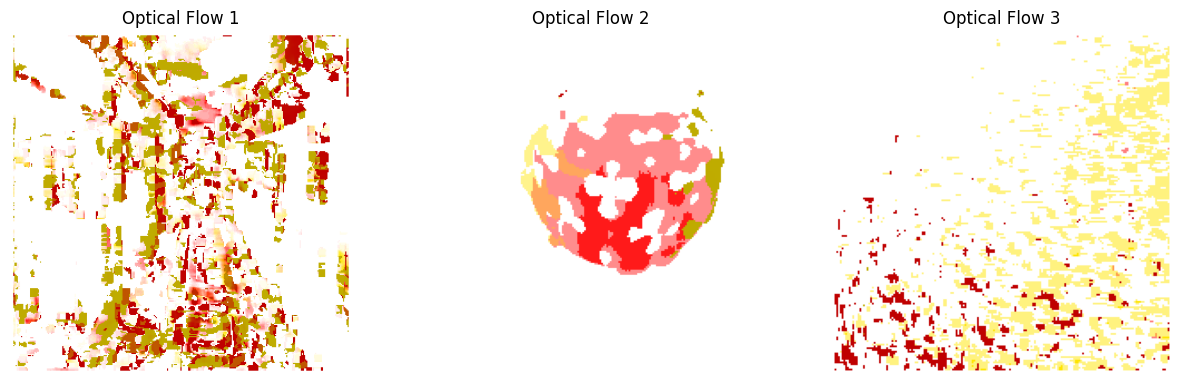

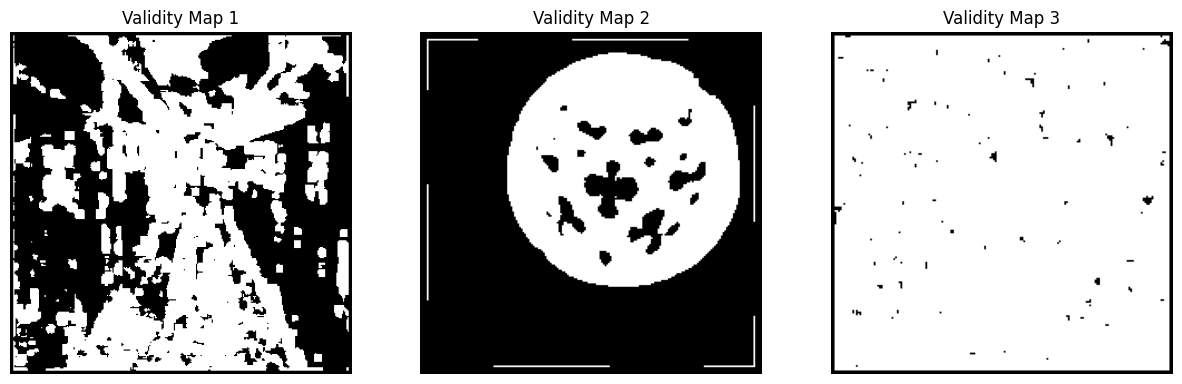

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def flowToColor(flow, maxflow=None, verbose=False):
    '''
    args
        flow (numpy array) height x width x 2
    return
        img_color (numpy array) height x width x 3
    '''

    UNKNOWN_FLOW_THRESH = 5e2
    eps = 1e-6

    height, widht, nBands = flow.shape

    if nBands != 2:
        exit('flowToColor: image must have two bands')

    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999
    maxv = -999

    minu = 999
    minv = 999
    maxrad = -1

    # fix unknown flow
    idxUnknown = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknown] = 0
    v[idxUnknown] = 0

    maxu = max(maxu, u.max())
    minu = min(minu, u.min())

    maxv = max(maxv, v.max())
    minv = min(minv, v.min())

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(maxrad, rad.max())

    if verbose:
        print('max flow: %.4f flow range: u = %.3f .. %.3f; v = %.3f .. %.3f\n' %
              (maxrad, minu, maxu, minv, maxv))

    if maxflow is not None:
        if maxflow > 0:
            maxrad = maxflow

    u = u / (maxrad + eps)
    v = v / (maxrad + eps)

    img = computeColor(u, v)

    # unknown flow
    # IDX = repmat(idxUnknown, [1, 1, 3])
    img[idxUnknown] = 0

    return img

def computeColor(u, v, cast_uint8=True):
    '''
    args
        u (numpy array) height x width
        v (numpy array) height x width
        cast_uint8 (bool) set False to have image range 0-1 (np.float32)
    return
        img_color (numpy array) height x width x 3
    '''

    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = makeColorwheel()
    ncols = colorwheel.shape[0]

    rad = np.sqrt(u ** 2 + v ** 2)

    a = np.arctan2(-v, -u)/np.pi

    fk = (a + 1) / 2 * (ncols - 1)  # -1~1 maped to 1~ncols

    k0 = np.floor(fk).astype(int)  # 1, 2, ..., ncols

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1

    f = fk - k0

    height, width = u.shape
    img = np.zeros((height, width, 3), np.float32)
    nrows = colorwheel.shape[1]
    for i in range(nrows):
        tmp = colorwheel[:, i]
        col0 = tmp[k0.reshape(-1)] / 255
        col1 = tmp[k1.reshape(-1)] / 255
        col = col0.reshape(height, width) * (1 - f) + \
              col1.reshape(height, width) * f

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])  # increase saturation with radius

        col[np.logical_not(idx)] *= 0.75  # out of range

        img[:, :, i] = col * (1 - nanIdx)

    if cast_uint8:
        img = np.floor(img * 255).astype(np.uint8)
    return img


def makeColorwheel():
    '''
    color encoding scheme
    adapted from the color circle idea described at
    http://members.shaw.ca/quadibloc/other/colint.htm
    '''

    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros((ncols, 3))  # r g b

    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.floor(255*np.array(range(RY))/RY)
    col = col+RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.floor(255*np.array(range(YG))/YG)
    colorwheel[col:col+YG, 1] = 255
    col = col+YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.floor(255*np.array(range(GC))/GC)
    col = col+GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.floor(255*np.array(range(CB))/CB)
    colorwheel[col:col+CB, 2] = 255
    col = col+CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.floor(255*np.array(range(BM))/BM)
    col = col+BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.floor(255*np.array(range(MR))/MR)
    colorwheel[col:col+MR, 0] = 255

    return colorwheel


def myFlow(img1, img2, window_length, threshold, resize_f):

    # Read the image
    img_1 = cv2.imread(img1)
    img_2 = cv2.imread(img2)

     # Resize the images
    resized_img1 = cv2.resize(img_1, None, fx=resize_f, fy=resize_f)
    resized_img2 = cv2.resize(img_2, None, fx=resize_f, fy=resize_f)
    
    # Convert the images to grayscale
    gray_image = cv2.cvtColor(resized_img1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(resized_img2, cv2.COLOR_BGR2GRAY)

    # Normalize intensity values to the range [0, 1]
    normalized_image = gray_image / 255.0
    normalized_image_2 = gray_image2 / 255.0
    
    # Define the filter kernel
    kernel = np.array([-1, 8, 0, -8, 1]) / 12.0
    w = int(window_length/2)
    # Apply convolution to compute spatial derivatives for the first frames
    Ix = cv2.filter2D(normalized_image, -1, kernel.reshape(1, -1))
    Iy = cv2.filter2D(normalized_image, -1, kernel.reshape(-1, 1))
    
    # Compute temporal derivative by subtracting the Gaussian filtered images
    gaussian_kernel_size = (3, 3)
    sigma = 1
    img1_gaussian = cv2.GaussianBlur(normalized_image, gaussian_kernel_size, sigma)
    img2_gaussian = cv2.GaussianBlur(normalized_image_2, gaussian_kernel_size, sigma)
    temporal_derivative = normalized_image_2 - normalized_image  

    # Initialize arrays to store flow components and validity map
    height, width = gray_image.shape
    u = np.zeros_like(gray_image)
    v = np.zeros_like(gray_image)
    Valid_Flow = np.zeros_like(gray_image, dtype=bool)
 
    # Loop over each pixel
    for i in range(w, normalized_image.shape[0]-w):
        for j in range(w, normalized_image.shape[1]-w):
        # Extract patches
            A_IX = Ix[i - w: i + w + 1, j - w: j + w +1].flatten()
            A_IY = Iy[i - w: i + w + 1, j - w: j + w +1].flatten()
            ITR_B = temporal_derivative[i-w:i+w+1, j-w:j+w+1].flatten()

        # Construct the structure tensor A
            A = np.column_stack((A_IX, A_IY))

        # Compute the smallest eigenvalue
            EignV = np.linalg.eigvalsh(np.dot(A.T, A))

        # Check if the smallest eigenvalue satisfies the threshold
            if EignV.min() > threshold:
            # Compute velocity
                velocity = np.matmul(np.linalg.pinv(A),ITR_B)
            # Store the flow vector components
                u[i, j] = velocity[0]
                v[i, j] = velocity[1]
                Valid_Flow[i, j] = True

    
    return (u,v, Valid_Flow)


image1_1, image2_1, Valid_Flow1 = myFlow("bt_0.png", "bt_1.png", 7, 0.001, 1.2)
image1_2, image2_2, Valid_Flow2 = myFlow("sphere_0.png", "sphere_1.png", 9, 0.001, 1)
image1_3, image2_3, Valid_Flow3 = myFlow("synth_0.png", "synth_1.png", 5, 0.001, 1.5)

# Visualize the computed optical flow for each pair of images
flow1 = np.stack((image1_1, image2_1), axis=-1)
flow2 = np.stack((image1_2, image2_2), axis=-1)
flow3 = np.stack((image1_3, image2_3), axis=-1)

flow_color1 = flowToColor(flow1)
flow_color2 = flowToColor(flow2)
flow_color3 = flowToColor(flow3)

# Plot the optical flow visualizations
plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(flow_color1)
plt.title('Optical Flow 1')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(flow_color2)
plt.title('Optical Flow 2')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(flow_color3)
plt.title('Optical Flow 3')
plt.axis('off')


plt.show()

# Plot binary maps indicating validity of optical flow
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(Valid_Flow1, cmap='gray')
plt.title('Validity Map 1')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Valid_Flow2, cmap='gray')
plt.title('Validity Map 2')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Valid_Flow3, cmap='gray')
plt.title('Validity Map 3')
plt.axis('off')

plt.show()

## The window size in the Lucas-Kanade optical flow algorithm directly impacts the accuracy, 
## smoothness, and computational cost of the computed optical flow vectors. 
## A smaller window size captures finer motion details but may be more susceptible to noise and texture variations, 
## leading to potentially noisier flow fields. On the other hand, a larger window size provides more robust estimates 
## by averaging motion over a larger area, resulting in smoother flow fields but potentially losing finer motion details. 
## However, larger window sizes also increase computational cost due to the need to process larger neighborhoods. 
## Adjusting the window size requires a trade-off between capturing fine details and producing smooth results, 
## with the choice depending on the specific characteristics of the images and the desired balance between accuracy 
## and smoothness in the optical flow estimation.

## The window size in the Lucas-Kanade optical flow algorithm directly impacts the accuracy, smoothness, and computational cost of the computed optical flow vectors.

A smaller window size captures finer motion details but may be more susceptible to noise and texture variations, leading to potentially noisier flow fields. On the other hand, a larger window size provides more robust estimates by averaging motion over a larger area, resulting in smoother flow fields but potentially losing finer motion details.

However, larger window sizes also increase computational cost due to the need to process larger neighborhoods. Adjusting the window size requires a trade-off between capturing fine details and producing smooth results, with the choice depending on the specific characteristics of the images and the desired balance between accuracy and smoothness in the optical flow estimation.



### Second Part with Warping the Image
- I was able to calculate and warp the second image onto the first image and get almost the same image but the error is high as you can see in the plotted images. Also I was unable to use matplot's lib flushevents function to force python to render new image to existing plot.
- I did use my code from the first part to find the u and v 
- Thank you 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


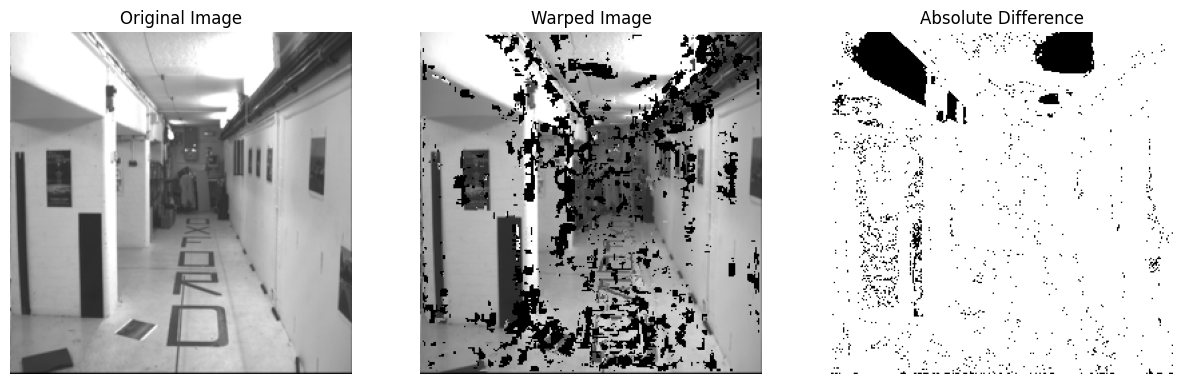

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


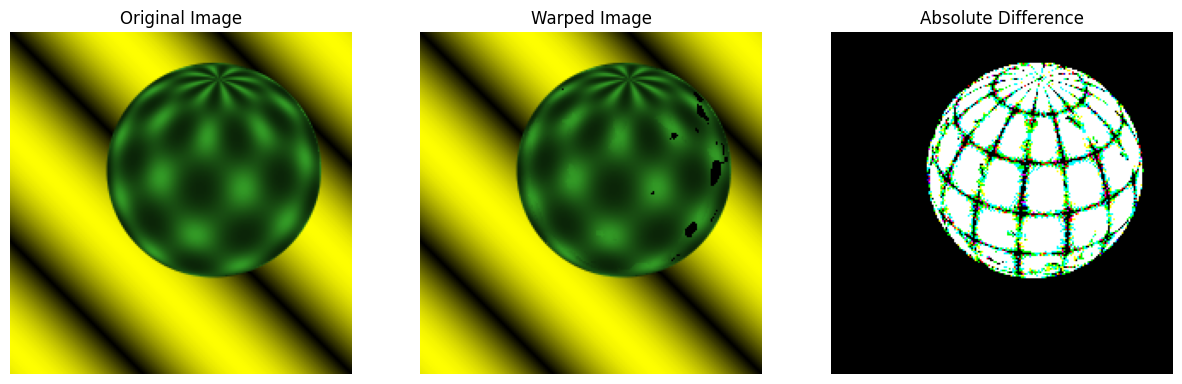

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


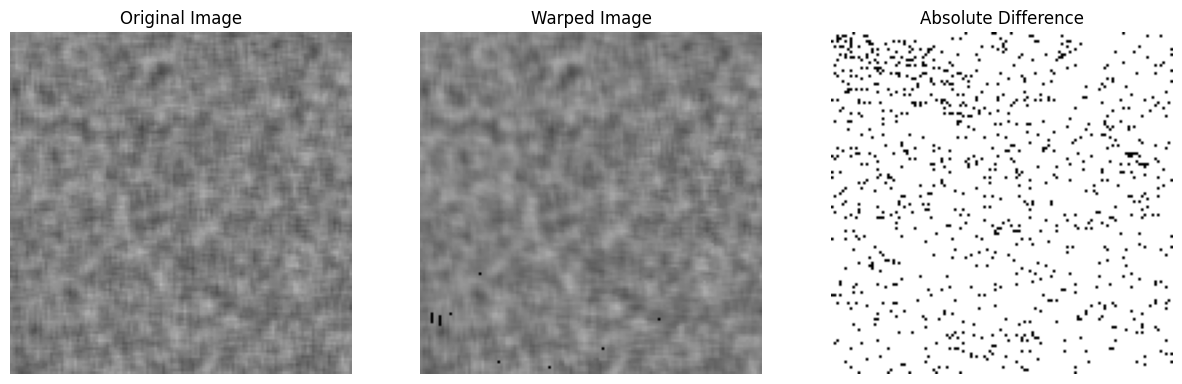

In [18]:
import cv2
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

def myFlow(img1, img2, window_length, threshold):

    # Read the image
    img_1 = cv2.imread(img1)
    img_2 = cv2.imread(img2)
    
    # Convert the images to grayscale
    gray_image = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

    # Normalize intensity values to the range [0, 1]
    normalized_image = gray_image / 255.0
    normalized_image_2 = gray_image2 / 255.0
    
    # Define the filter kernel
    kernel = np.array([-1, 8, 0, -8, 1]) / 12.0
    w = int(window_length/2)
    # Apply convolution to compute spatial derivatives for the first frames
    Ix = cv2.filter2D(normalized_image, -1, kernel.reshape(1, -1))
    Iy = cv2.filter2D(normalized_image, -1, kernel.reshape(-1, 1))
    
    # Compute temporal derivative by subtracting the Gaussian filtered images
    gaussian_kernel_size = (3, 3)
    sigma = 1
    img1_gaussian = cv2.GaussianBlur(normalized_image, gaussian_kernel_size, sigma)
    img2_gaussian = cv2.GaussianBlur(normalized_image_2, gaussian_kernel_size, sigma)
    temporal_derivative = normalized_image_2 - normalized_image  

    # Initialize arrays to store flow components and validity map
    height, width = gray_image.shape
    u = np.zeros_like(gray_image)
    v = np.zeros_like(gray_image)

 
    # Loop over each pixel
    for i in range(w, normalized_image.shape[0]-w):
        for j in range(w, normalized_image.shape[1]-w):
        # Extract patches
            A_IX = Ix[i - w: i + w + 1, j - w: j + w +1].flatten()
            A_IY = Iy[i - w: i + w + 1, j - w: j + w +1].flatten()
            ITR_B = temporal_derivative[i-w:i+w+1, j-w:j+w+1].flatten()

        # Construct the structure tensor A
            A = np.column_stack((A_IX, A_IY))

        # Compute the smallest eigenvalue
            EignV = np.linalg.eigvalsh(np.dot(A.T, A))

        # Check if the smallest eigenvalue satisfies the threshold
            if EignV.min() > threshold:
            # Compute velocity
                velocity = np.matmul(np.linalg.pinv(A),ITR_B)
            # Store the flow vector components
                u[i, j] = velocity[0]
                v[i, j] = velocity[1]

    
    return (u,v)
    
def myWarp(img2, u, v):
    # Get the shape of the input image
    height, width = img2.shape[:2]

    # Create a mesh grid for the pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Use the flow vectors to warp the coordinates
    warped_x = x + u
    warped_y = y + v
    
    # Perform backward warping with bilinear interpolation
    warped_img2 = cv2.remap(img2, warped_x.astype(np.float32), warped_y.astype(np.float32), cv2.INTER_LINEAR)
    resized_warped_img2 = cv2.resize(warped_img2, (width, height))
    
    return resized_warped_img2


def absolute_difference(img1, img2):
    return np.abs(img1.astype(float) - img2.astype(float))


u1, v1 = myFlow("bt_0.png", "bt_1.png", 5, 0.001)


# Warp img2 using the computed optical flow
img2 = cv2.imread("bt_1.png")
img1 = cv2.imread("bt_0.png")
warped_img = myWarp(img2, u1, v1)

# Compute the absolute difference between the original first image and the warped image
diff = absolute_difference(img1, warped_img)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='gray')
plt.title('Absolute Difference')
plt.axis('off')
plt.show()

# Load images and compute optical flow for the second pair
img1_2 = cv2.imread("sphere_0.png")
img2_2 = cv2.imread("sphere_1.png")
u2, v2 = myFlow("sphere_0.png", "sphere_1.png", 5, 0.001)

# Warp img2 using the computed optical flow
warped_img2 = myWarp(img2_2, u2, v2)

# Compute the absolute difference between the original first image and the warped image
diff2 = absolute_difference(img1_2, warped_img2)

# Display the original first image, warped image, and the absolute difference output for the second pair
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1_2, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(warped_img2, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff2, cmap='gray')
plt.title('Absolute Difference')
plt.axis('off')

plt.show()


# Load images and compute optical flow for the third pair
img1_3 = cv2.imread("synth_0.png")
img2_3 = cv2.imread("synth_1.png")
u3, v3 = myFlow("synth_0.png", "synth_1.png", 5, 0.001)

# Warp img2 using the computed optical flow
warped_img3 = myWarp(img2_3, u3, v3)

# Compute the absolute difference between the original first image and the warped image
diff3 = absolute_difference(img1_3, warped_img3)

# Display the original first image, warped image, and the absolute difference output for the third pair
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1_3, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(warped_img3, cv2.COLOR_BGR2RGB))
plt.title('Warped Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(diff3, cmap='gray')
plt.title('Absolute Difference')
plt.axis('off')

plt.show()

## Third Part for Implementing the Kanade-Lucas-Tomasi (KLT) tracker ##
- I have used the function calcOpticalFlowPyrLK which uses Kanade Lucas to find the points in the second frame and used that to find the validity of my flow as well, I also learned that from that from https://github.com/nirmal-25/Kanade-Lucas-Tomasi-KLT-feature-tracker/blob/master/klt_tracker.ipynb this github and I wanted to site it because I did not know who to reach for asking whether I should use this function or not but I got my idea from this website but did not use any code from it just needed to put it in here.
- I couldn't also display the overlay of the keypoints which were moved outside the frame because I did not fully understand their movements, and these have been already discarded in the function that I mentioned, again thank you for going through my code. 
- I also was not able to display the 2D path of keypoints using line segments I tried but could not get them all in one image :')


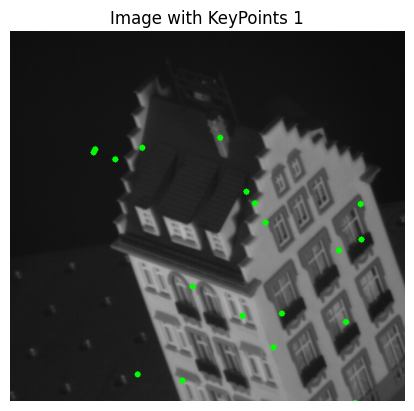

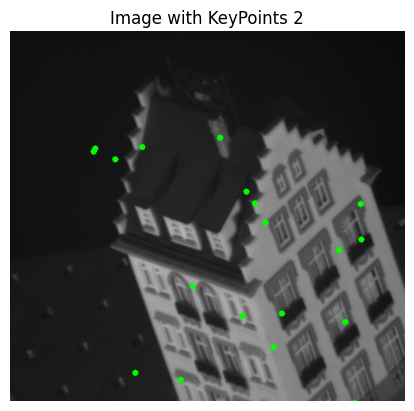

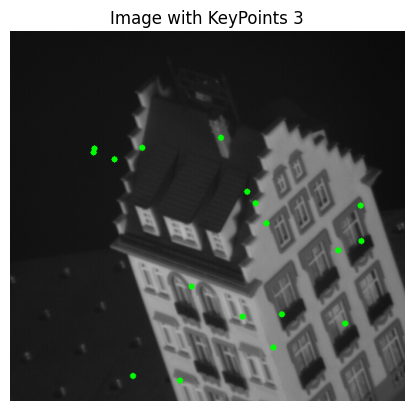

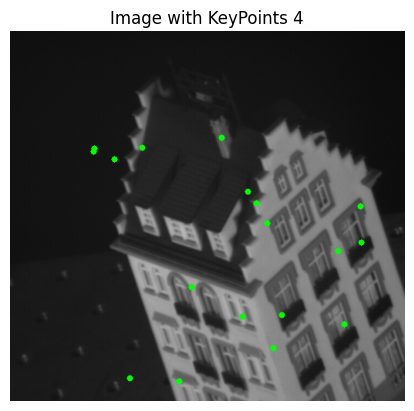

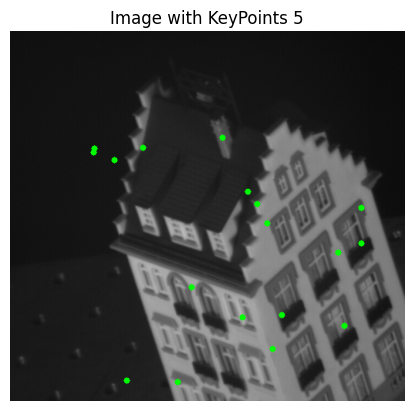

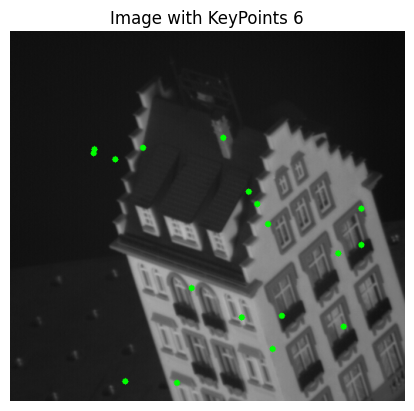

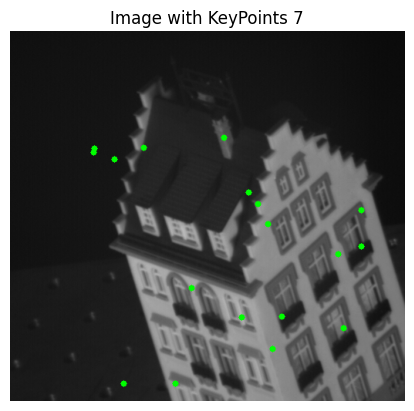

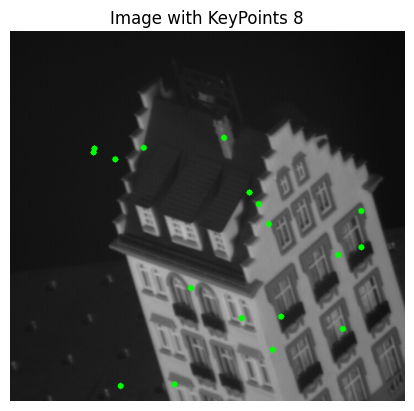

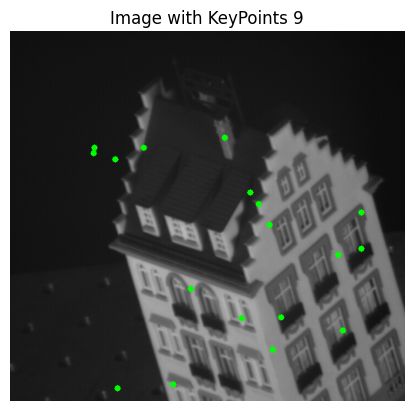

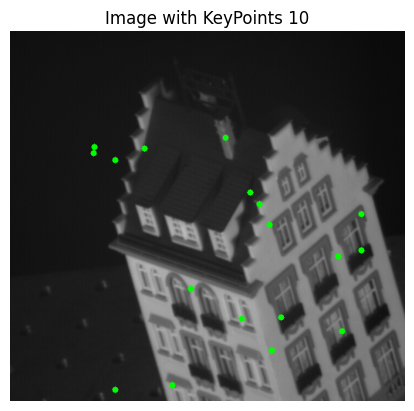

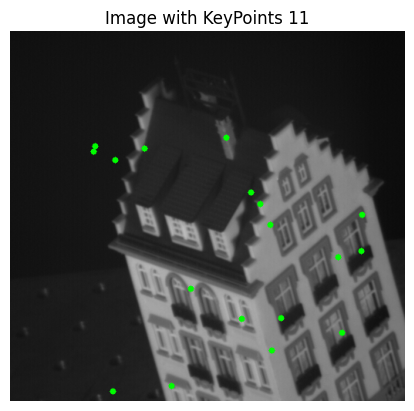

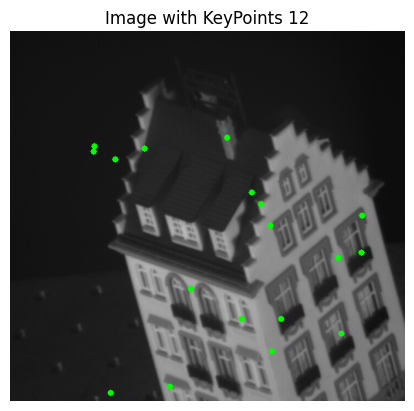

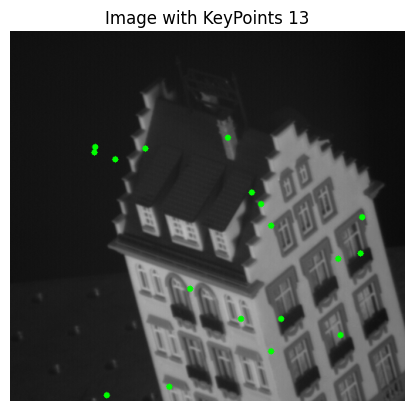

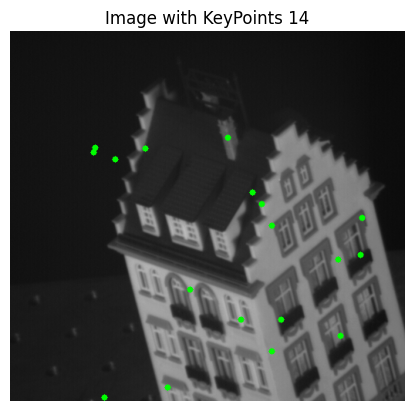

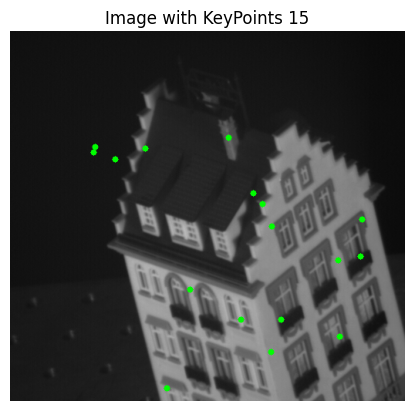

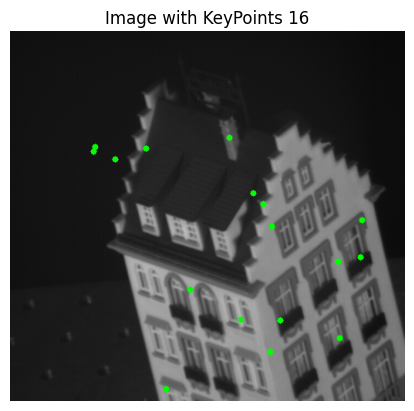

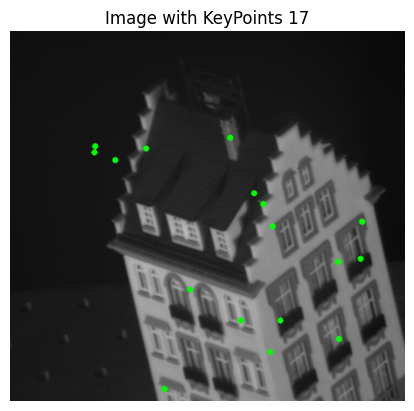

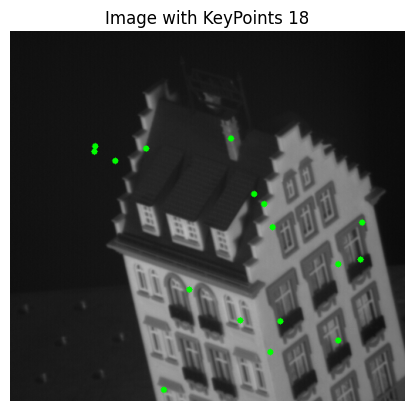

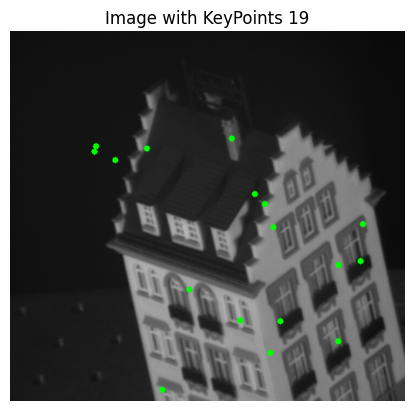

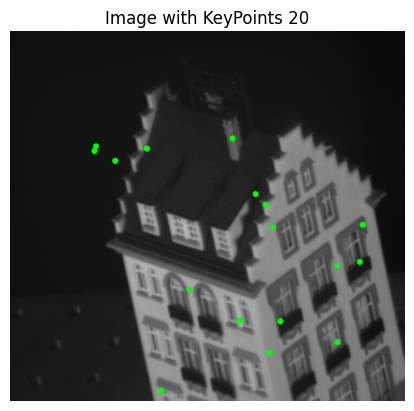

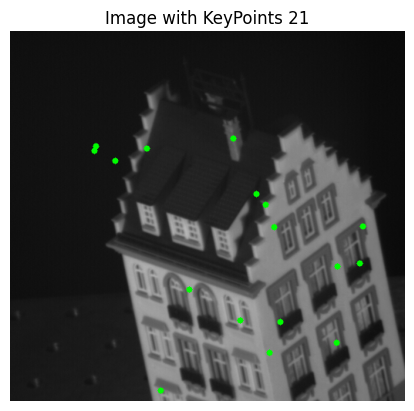

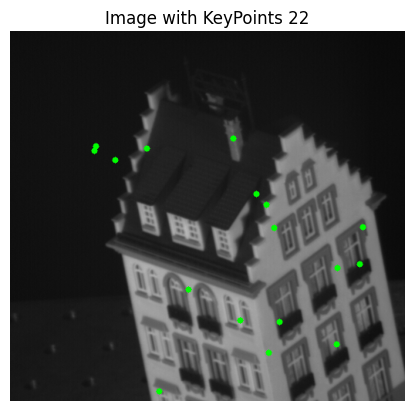

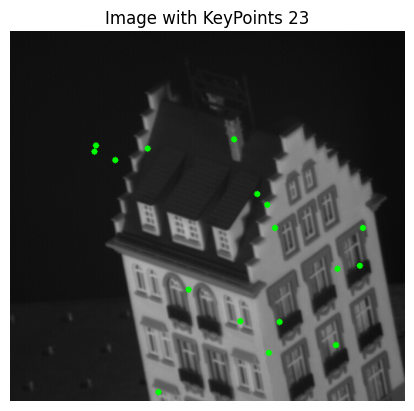

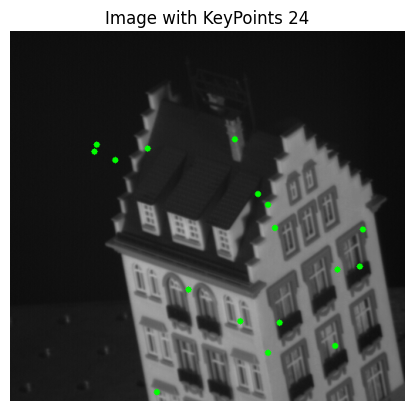

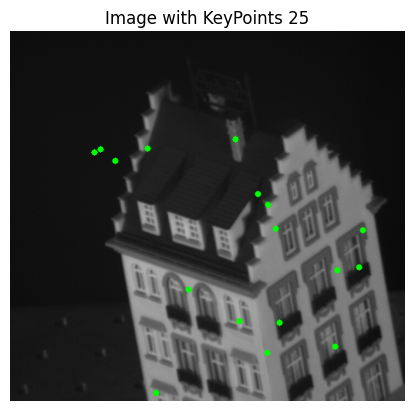

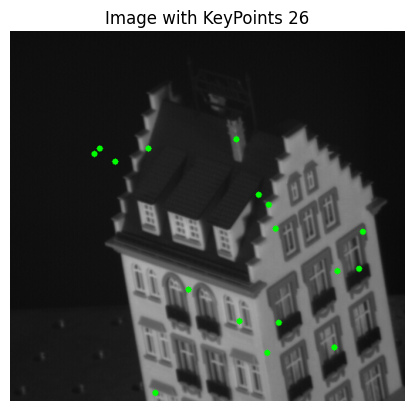

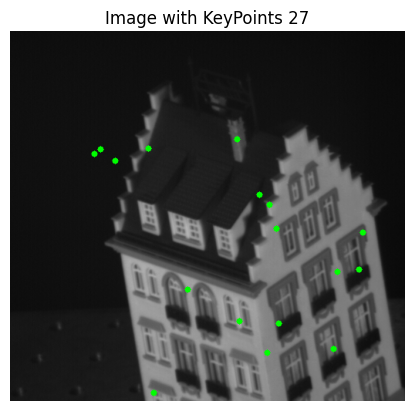

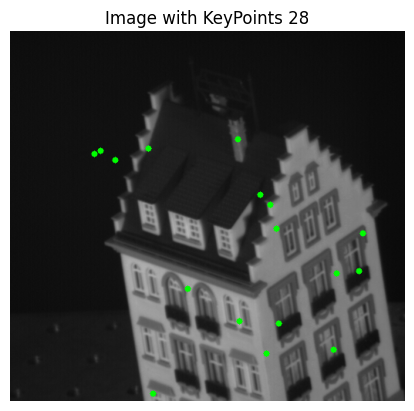

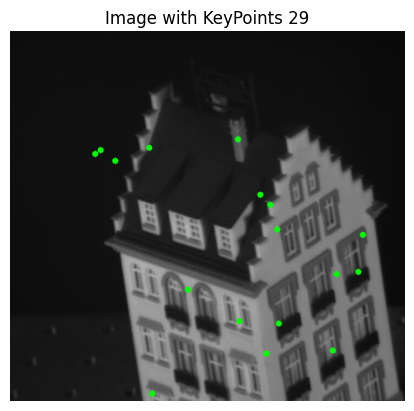

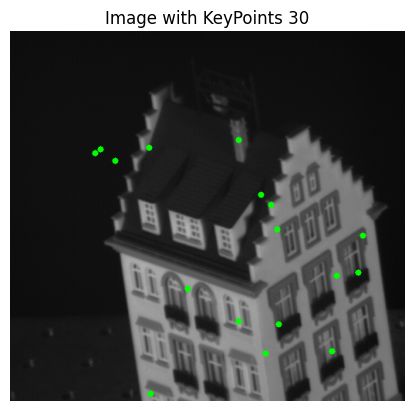

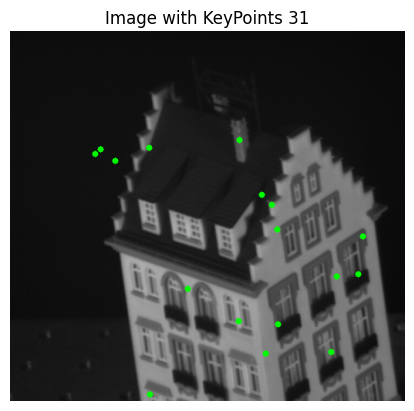

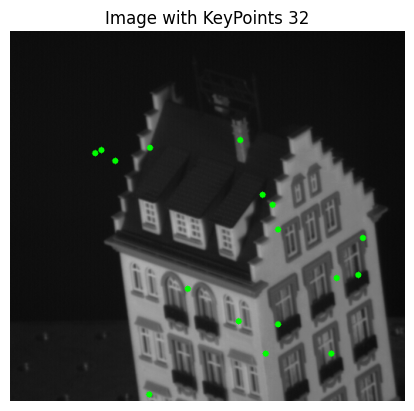

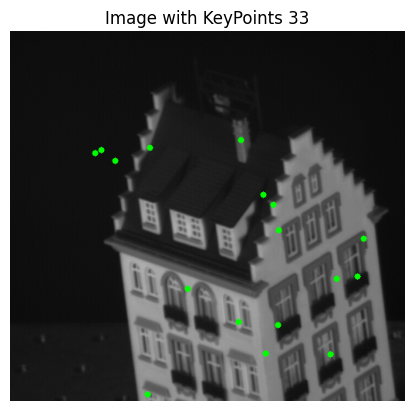

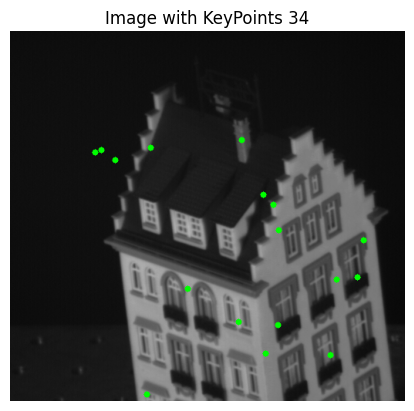

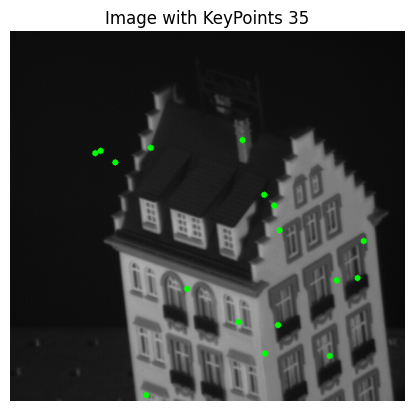

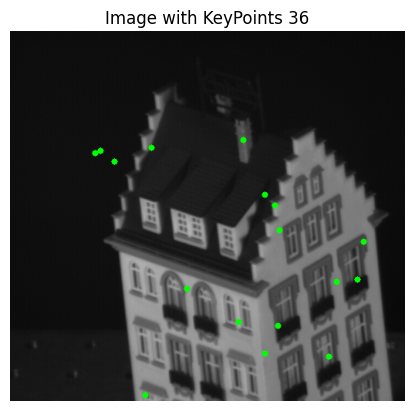

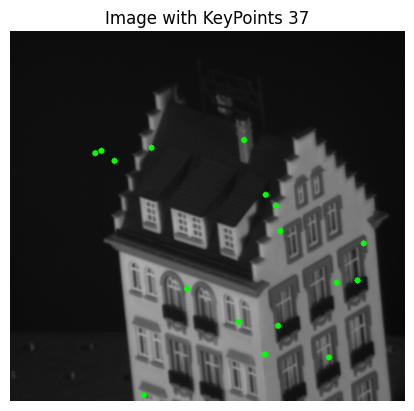

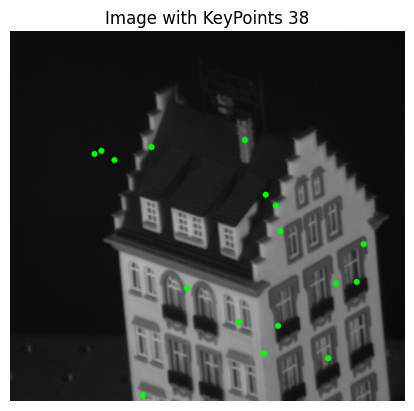

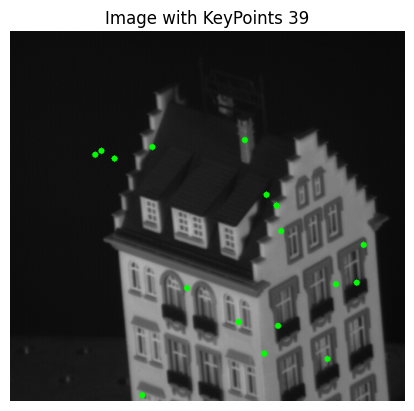

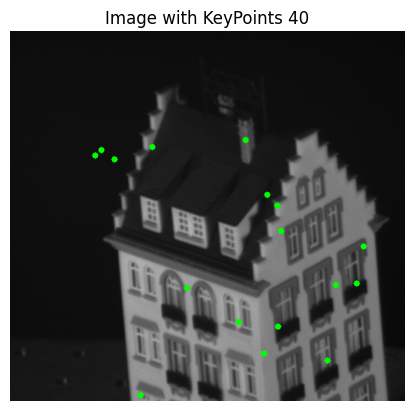

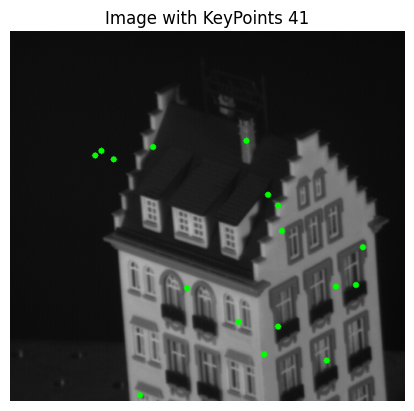

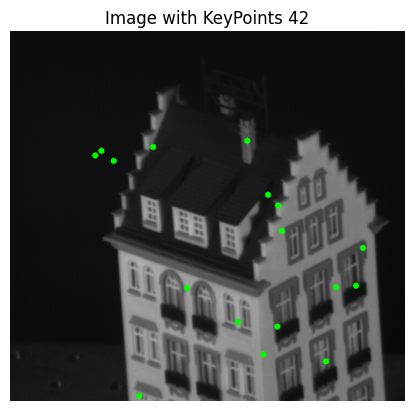

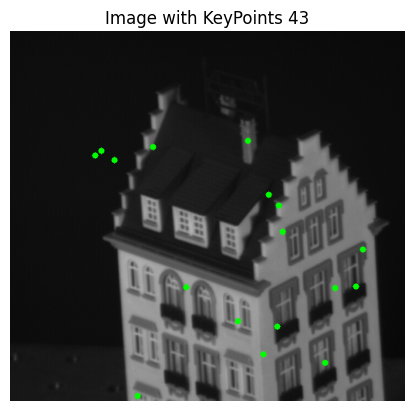

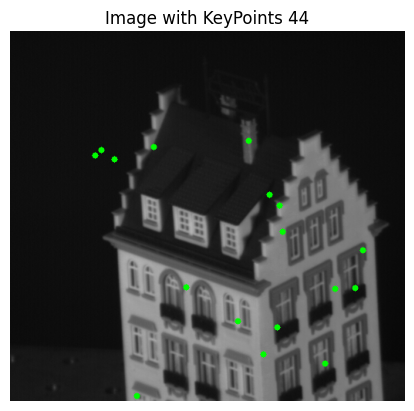

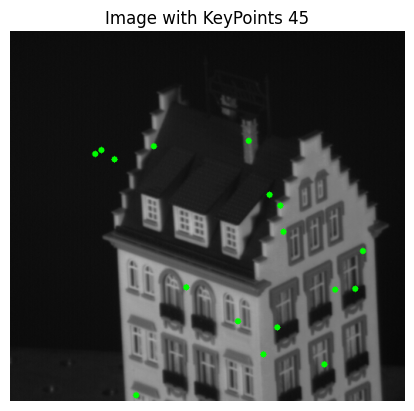

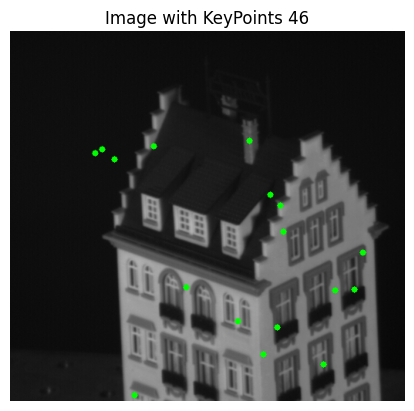

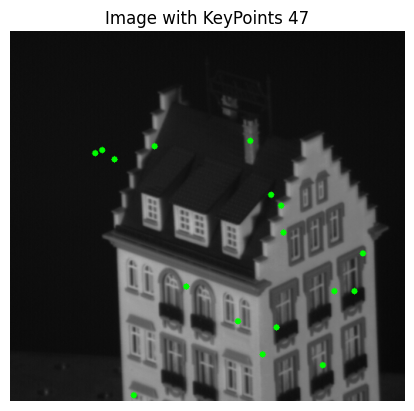

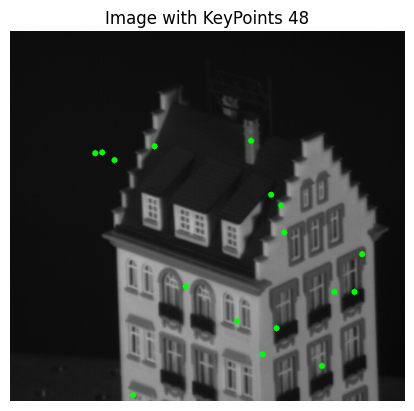

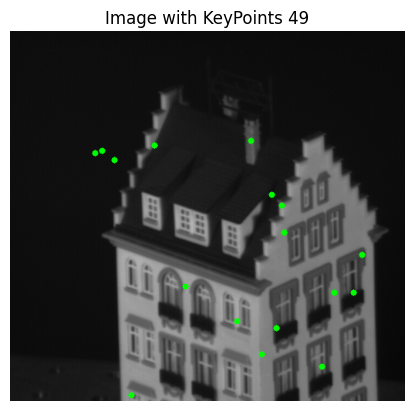

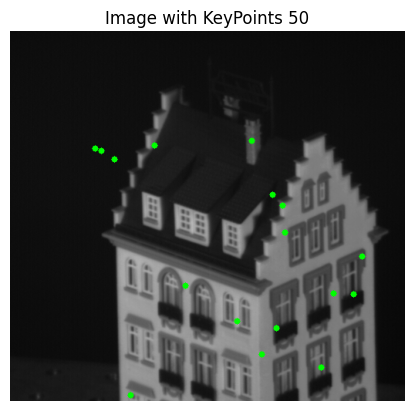

In [19]:
import numpy as np
import cv2
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt


def Harris_Point(img):
    im = cv2.imread('hotel.seq0.png')
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    sigma = 5
    k = 0.04

    # Apply Gaussian blur
    im_blurred = cv2.GaussianBlur(im_gray, (0, 0), sigma)

    # Compute derivatives using Sobel operators
    Ix = cv2.Sobel(im_blurred, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(im_blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Compute products of derivatives
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    # Apply Gaussian filter to the products of derivatives
    Ix2_blurred = cv2.GaussianBlur(Ix2, (0, 0), sigma)
    Iy2_blurred = cv2.GaussianBlur(Iy2, (0, 0), sigma)
    Ixy_blurred = cv2.GaussianBlur(Ixy, (0, 0), sigma)

    # Compute Harris response
    det_M = Ix2_blurred * Iy2_blurred - Ixy_blurred ** 2
    trace_M = Ix2_blurred + Iy2_blurred
    r = det_M - k * (trace_M ** 2)

    # Threshold and normalize response
    thresh = 0.01 * np.max(r)
    r_threshed = (r > thresh).astype(np.uint8) * 255

    # Find Harris corner coordinates
    coordinates = np.argwhere(r > thresh)

    # Select 20 random keypoints
    num_keypoints = 20
    random_indices = np.random.choice(coordinates.shape[0], num_keypoints, replace=False)
    random_keypoints = coordinates[random_indices]
    return random_keypoints
    

# Parameters for Lucas-Kanade optical flow
lucas_parameters = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
prev_keypoints = None
for i in range(50):
    image = cv2.imread(f'hotel.seq{i}.png')
    image_2 = cv2.imread(f'hotel.seq{i + 1}.png')

    if prev_keypoints is None:
        # Detecting keypoints in the first image
        keypoints_1 = Harris_Point(image)
        # Converting keypoints to float32 format
        keypoints_1 = keypoints_1.reshape(-1, 1, 2).astype(np.float32)
        prev_keypoints = keypoints_1 
   
        

    keypoints_2, status, _ = cv2.calcOpticalFlowPyrLK(image, image_2, keypoints_1, None, **lucas_parameters)
    keypoints_1 = keypoints_2[status == 1]
    keypoints_1 = keypoints_1.reshape(-1, 1, 2).astype(np.float32)

    for keypoints in prev_keypoints:
        x1, y1 = keypoints.ravel()
        cv2.circle(image_2, (int(x1), int(y1)), 4, (0, 255, 0), -1)
        
    plt.imshow(image_2)
    plt.title(f'Image with KeyPoints {i + 1}')
    plt.axis('off')
    plt.show()

    prev_keypoints = keypoints_1

